### Project Objective
This notebook aims to build a predictive model to estimate hospital readmission outcomes for diabetes patients. The target variable, readmitted, has three classes: NO, <30 days, and >30 days.

Purpose: 
Accurate predictions of readmission risk can help hospitals allocate resources more efficiently. Patients identified as high risk (especially those likely to return within 30 days) can receive tailored interventions, improved monitoring, or optimized discharge planning. This may reduce unnecessary readmissions and improve bed and staff utilization.

### Note: Why the <30 Days Readmission Class Matters

Readmissions within 30 days are widely used in healthcare as a key quality indicator. They often signal unresolved medical issues, inadequate discharge planning, or complications that arise shortly after the patient leaves the hospital. Hospitals typically monitor this category closely because these readmissions are considered more preventable and are sometimes tied to financial or performance evaluations.
For this reason, achieving strong model performance on the <30 class is particularly valuable for clinical decision-making and resource planning.

### Dataset Information

Source

The dataset is sourced from Kaggle. A preprocessed version of the data is used in this notebook; missing values have been handled, relevant feature engineering has been performed, and unnecessary columns have been removed. We will load the dataset from the file cleaned_df.pkl.

What Each Row Represents

Each row corresponds to an individual patient encounter, containing demographic details, medical history, and hospital-related information such as medications, procedures, and diagnostic attributes.

Major Feature Categories:

1) Demographics (age, gender, race, etc.)

2) Medication-related variables

3) Lab tests and procedures

4) Encounter and admission details

Problem Type
This is a multiclass classification task in which the goal is to predict patient readmission outcomes into three categories: NO, <30 days, and >30 days.

# 1) Initial Data Checks
i) load the pickle file from ../Data/Processed/cleaned_df.pkl

ii) print head to check the contents and if the pickle file is loaded correctly

iii) review the structure and column types to get an idea about the dataframe and if it needs any further processing

iv) check the summary statistics to look for any unusal trends or patterns in the data

v) Check the distribution of the class variable to see if it balanced or unbalanced so that it could be handled accordingly during modelling step

# 2) Modelling Approach

i) Models to Try and Rationale

Begin with a simple baseline model such as Logistic Regression to establish reference performance using accuracy, precision, recall, and F1-score. If performance is limited, explore more complex algorithms including Support Vector Machines (SVM), Decision Trees, Random Forests, Bagging and Boosting methods, and Artificial Neural Networks (ANN). Each model will be tuned through appropriate hyperparameters to improve predictive performance.

ii) Data Splitting Strategy

Because this is a multiclass classification problem, the dataset will be split into training and testing sets using a stratified train–test split to ensure the class proportions are preserved across both sets.

iii) Evaluation Metrics

Model performance will be evaluated using precision, recall, F1-score, and confusion matrices to understand class-wise behavior and overall predictive capability.

iv) Model Comparison Approach

Models will be compared using their confusion matrices and aggregate performance metrics. Special attention will be given to maintaining a strong balance between recall and F1-score, especially for the clinically important <30 days readmission class.

v) Constraints and Considerations

Potential class imbalance may affect model performance, particularly for minority classes. If needed, techniques such as class weighting or resampling will be considered during model development

# 3) Modelling Data Preparation

1. Feature Selection

All feature cleaning, removal of highly correlated variables, and elimination of irrelevant columns were completed during preprocessing. In this notebook, all remaining columns will be used as features, with readmitted serving as the target variable.

2. Handling Categorical and Numerical Variables

Numerical features: Standardized using StandardScaler.
Categorical features:
Low-cardinality categories: Encoded using One-Hot Encoding (OHE).
High-cardinality categories: Encoded using Target Encoding to reduce dimensionality and maintain signal strength.

3. Preprocessing Structure (Pipeline and ColumnTransformer)
A ColumnTransformer will be used to apply different transformations to numerical and categorical features.
A Pipeline will incorporate preprocessing and the selected model, ensuring consistent and reproducible transformations during training and evaluation.

4. Handling Class Imbalance
If class imbalance is observed, techniques such as SMOTE or alternative balancing strategies may be applied to improve minority-class performance.

5. Reproducibility
A fixed random_state will be used throughout the workflow, and the train–test split will be stratified to maintain class proportions in both sets.

# 4) Baseline Model plan (logistic Regression)

1. Purpose of the Baseline Model

i) Establish an initial performance benchmark for all subsequent models.

ii) Assess the overall difficulty of the prediction task.

iii) Gain early insights into data behavior and model fit, helping determine whether additional EDA or feature engineering may be needed.

2. Evaluation Metrics
The baseline model will be evaluated using:

i) Precision

ii) Recall

iii) F1-score

iv) Confusion matrix
These metrics will provide class-level insights, particularly for the clinically important <30 days readmission class.

3. Decisions Guided by the Baseline Results

i) Whether more complex models are required to improve performance.

ii) Whether class imbalance needs additional treatment (e.g., SMOTE, class weights).

iii) Whether the preprocessing pipeline (scaling, encoding) is functioning as expected.

# 5) Model Training Workflow Plan

i) Load the data

ii) Separate the target and feature columns

iii) Split into training and testing set

iv) Apply the column transformations

v) Train the baseline logistic regression

vi) Evaluate the base line model

vii) Iterate and tune the parameters

viii) Iterate with more models

ix) Compare performance across models

x) Choose final model

In [255]:
import pickle
with open('../Data/Processed/cleaned_df.pkl', 'rb') as f:
    cleaned_df=pickle.load(f)
print(cleaned_df.shape)
print(cleaned_df.head())
print(cleaned_df.info())
print(cleaned_df.describe())
print(cleaned_df['readmitted'].value_counts())

(101766, 45)
              race  gender      age  weight  admission_type_id  \
0        Caucasian  Female   [0-10)       0                  6   
1        Caucasian  Female  [10-20)       0                  1   
2  AfricanAmerican  Female  [20-30)       0                  1   
3        Caucasian    Male  [30-40)       0                  1   
4        Caucasian    Male  [40-50)       0                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        25                    1                 1   
1                         1                    7                 3   
2                         1                    7                 2   
3                         1                    7                 2   
4                         1                    7                 1   

          medical_specialty  num_lab_procedures  ...  glipizide-metformin  \
0  Pediatrics-Endocrinology                  41  ...                   No   
1              

In [256]:
#Separating feature and target columns and splitting the data into test and train
from sklearn.model_selection import train_test_split
#y=cleaned_df['readmitted']
X=cleaned_df.drop('readmitted', axis=1)
# y: 3-class target 
y = cleaned_df['readmitted'].map({
    'NO': 0,
    '>30': 0,
    '<30': 1
})
X_train, X_test, y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [257]:
numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include='object').columns

In [258]:
# defining low and high cardinality columns
low_cardinality_cols=[]
high_cardinality_cols=[]
for col in categorical_cols:
    if (X[col].nunique()>10):
        high_cardinality_cols.append(col)
    else:
        low_cardinality_cols.append(col)

print("high cardinality : ",high_cardinality_cols)
print("low cardinality : ",low_cardinality_cols)

high cardinality :  ['medical_specialty', 'diag_1_category', 'diag_2_category', 'diag_3_category']
low cardinality :  ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [259]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
preprocess= ColumnTransformer(transformers=[
    ("numeric_cols",StandardScaler(), numeric_cols),
    ("low_cardinality_cols", OneHotEncoder(handle_unknown="ignore"), low_cardinality_cols),
    ("high_cardinality_cols", TargetEncoder(), high_cardinality_cols)  
])

In [260]:
# Training the baseline logistic regression model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
pipe=Pipeline(steps=[
    ("preprocess", preprocess),
    ("logistic_regression", LogisticRegression(max_iter=300, class_weight='balanced'))
])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

In [261]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))
#The baseline logistic regression model performs adequately for the majority “NO” class but struggles with early readmission prediction. 
# In particular, the <30 class shows low recall and precision, with substantial confusion between <30 and >30 readmissions. 
# This suggests that linear decision boundaries are insufficient for capturing the complex patterns required to distinguish readmission timing, 
# motivating the use of more expressive models in subsequent experiments.

accuracy 0.6627689888965314
precision 0.5469726807119787
F1 Score 0.5215513415288193
Recall 0.6071029975703063
classification report               precision    recall  f1-score   support

           0       0.92      0.68      0.78     18083
           1       0.17      0.54      0.26      2271

    accuracy                           0.66     20354
   macro avg       0.55      0.61      0.52     20354
weighted avg       0.84      0.66      0.72     20354

confusion_matrix [[12274  5809]
 [ 1055  1216]]


In [262]:
cleaned_df.readmitted.value_counts(normalize=True)

readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64

In [263]:
# Right now the LR model predicts a certain class if it has >=0.5 probability; lower the probability threshold and reanalyse the results
#PR-AUC > prevalence = model is useful ; here prevalence is ~0.11
y_proba = pipe.predict_proba(X_test)[:, 1]

from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", pr_auc)

PR-AUC: 0.2026673773602622


Precision–Recall AUC Interpretation (Imbalanced Setting)

The dataset is highly imbalanced, with early readmissions (<30 days) accounting for only ~11.2% of observations. In such cases, PR-AUC is more informative than accuracy or ROC-AUC, as it focuses on performance for the minority (clinically important) class.

The Logistic Regression model achieves a PR-AUC of 0.203, compared to a baseline PR-AUC of ~0.112 (random classifier equal to class prevalence). This indicates that the model is substantially better than random at ranking patients by early readmission risk.

Although the absolute PR-AUC value may appear low, this is expected in healthcare risk prediction tasks with severe class imbalance. The result confirms that the model has learned meaningful signal and that its probability outputs are suitable for decision-threshold optimization to prioritize recall of high-risk patients

Threshold 0.5: Precision=0.173, Recall=0.535, F1=0.262
Threshold 0.4: Precision=0.132, Recall=0.875, F1=0.229
Threshold 0.35: Precision=0.119, Recall=0.962, F1=0.212
Threshold 0.3: Precision=0.113, Recall=0.994, F1=0.204


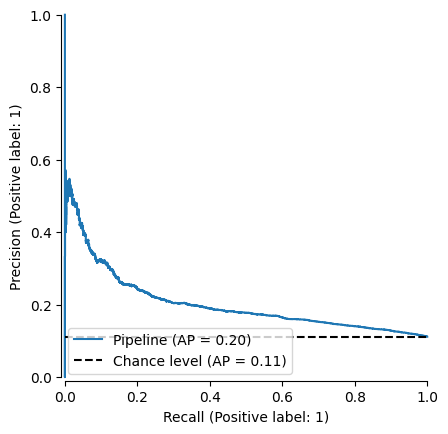

In [264]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
thresholds_to_test=[0.5,0.4,0.35,0.3]
for t in thresholds_to_test:
    y_pred_t= (y_proba > t).astype(int)
    print(
    f"Threshold {t}: "
    f"Precision={precision_score(y_test, y_pred_t):.3f}, "
    f"Recall={recall_score(y_test, y_pred_t):.3f}, "
    f"F1={f1_score(y_test, y_pred_t):.3f}")

# PR-Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
display=PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test,plot_chance_level=True, despine=True)

Because early readmissions represent only ~11% of cases, we optimized the decision threshold instead of using the default 0.5. Lowering the threshold to 0.4 significantly improves recall (≈0.88) while maintaining reasonable discrimination (PR-AUC ≈0.20).

The selected threshold reflects a recall-first objective, minimizing false negatives at the cost of increased false positives. This trade-off is appropriate given the downstream use of predictions for risk stratification and care planning, rather than hard decisions.

In [232]:
param_grid = {
    "logistic_regression__C": [0.01, 0.1, 1, 10],
    "logistic_regression__penalty": ["l1", "l2"],
    "logistic_regression__solver": ["liblinear",'saga']  # supports both l1 & l2
}
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_mode

{'logistic_regression__C': 0.01, 'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'liblinear'}
0.19562930246252494


In [235]:
best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

print("Threshold:", threshold)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Threshold: 0.4
Precision: 0.12836085278674006
Recall: 0.8934390136503743
F1: 0.22447173359884942
ROC-AUC: 0.6465179166869691
PR-AUC (Average Precision): 0.1995175176562881

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.24      0.38     18083
           1       0.13      0.89      0.22      2271

    accuracy                           0.31     20354
   macro avg       0.54      0.57      0.30     20354
weighted avg       0.86      0.31      0.36     20354



In [276]:
# ===============================
# 1. Train–test split (RAW DATA)
# ===============================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# ===============================
# 2. Preprocessing
# ===============================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("low", OneHotEncoder(handle_unknown="ignore"), low_cardinality_cols),
        ("high", TargetEncoder(), high_cardinality_cols),
    ],
    remainder="drop"
)

# ===============================
# 3. Transform data
# ===============================

X_train_transformed = preprocess.fit_transform(X_train, y_train)
X_test_transformed  = preprocess.transform(X_test)

# ===============================
# 4. Apply SMOTE (TRAIN ONLY)
# ===============================

from imblearn.over_sampling import SMOTE
from collections import Counter

print("Original dataset shape:", Counter(y_train))

smote = SMOTE(random_state=20)
X_train_smote, y_train_smote = smote.fit_resample(
    X_train_transformed,
    y_train
)

print("After SMOTE:", Counter(y_train_smote))

# ===============================
# 5. Train Logistic Regression (L1)
# ===============================

from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(
    fit_intercept=True,
    penalty="l1",
    solver="liblinear",      # REQUIRED for L1
    max_iter=300,
    random_state=42
)

logit.fit(X_train_smote, y_train_smote)

# ===============================
# 6. (Optional) Create DataFrame with correct feature names
# ===============================

import pandas as pd

feature_names = preprocess.get_feature_names_out()

train_input_df = pd.DataFrame(
    X_train_smote,
    columns=feature_names
)

# (Optional) Inspect selected features (L1 sparsity)
selected_features = train_input_df.columns[logit.coef_[0] != 0]
print("Number of selected features:", len(selected_features))

# ===============================
# 7. Model Evaluation (TEST SET)
# ===============================

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    average_precision_score
)

# ---- Hard predictions (threshold = 0.5)
y_pred = logit.predict(X_test_transformed)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average="macro"))
print("Recall (macro):", recall_score(y_test, y_pred, average="macro"))
print("F1 Score (macro):", f1_score(y_test, y_pred, average="macro"))

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# ---- Probability-based metric (IMPORTANT for imbalance)
y_prob = logit.predict_proba(X_test_transformed)[:, 1]

pr_auc = average_precision_score(y_test, y_prob)
print("\nPR-AUC:", pr_auc)


Original dataset shape: Counter({0: 72326, 1: 9086})
After SMOTE: Counter({0: 72326, 1: 72326})
Number of selected features: 85
Accuracy: 0.6332416232681537
Precision (macro): 0.5434424979821842
Recall (macro): 0.6033838219397015
F1 Score (macro): 0.5062325404539275

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.64      0.76     18083
           1       0.17      0.56      0.26      2271

    accuracy                           0.63     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.63      0.70     20354

Confusion Matrix:
 [[11606  6477]
 [  988  1283]]

PR-AUC: 0.19841493201795582


In [214]:
# Decision Tree – Baseline Model
# This Decision Tree baseline is used to test whether non-linear rules and feature interactions improve early readmission prediction compared to Logistic Regression
from sklearn.tree import DecisionTreeClassifier
pipe=Pipeline(steps=[("preprocess", preprocess),
                     ("Decision_tree", DecisionTreeClassifier(random_state=42,))]
)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
# The baseline Decision Tree model underperforms Logistic Regression, particularly for the clinically important <30 readmission class, 
# indicating that a single tree is too unstable to capture the complex patterns required for early readmission prediction.

In [215]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))

accuracy 0.7983688709835904
precision 0.5233228666833799
F1 Score 0.524421415215401
Recall 0.5265163743103167
classification report               precision    recall  f1-score   support

           0       0.89      0.88      0.89     18083
           1       0.15      0.18      0.16      2271

    accuracy                           0.80     20354
   macro avg       0.52      0.53      0.52     20354
weighted avg       0.81      0.80      0.80     20354

confusion_matrix [[15849  2234]
 [ 1870   401]]


In [216]:
# Random Forest – Baseline Model
from sklearn.ensemble import RandomForestClassifier
pipe=Pipeline(steps=[("preprocess", preprocess),
                     ("Random_forest", RandomForestClassifier(random_state=42, class_weight='balanced'))])

pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

In [217]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))
# Neither SMOTE nor cost-sensitive learning improved Random Forest performance on the <30 class, 
# indicating that early readmissions are not well separated by rule-based splits. 
# This suggests that the predictive signal for <30 is subtle and overlapping, motivating the use of boosting-based methods that focus on hard-to-classify samples.

accuracy 0.8886214011987815
precision 0.7444526408970198
F1 Score 0.47573272040205444
Recall 0.5024208056918812
classification report               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.60      0.01      0.01      2271

    accuracy                           0.89     20354
   macro avg       0.74      0.50      0.48     20354
weighted avg       0.86      0.89      0.84     20354

confusion_matrix [[18075     8]
 [ 2259    12]]


In [218]:
# Gradient Boosting - Baseline Model
from sklearn.ensemble import GradientBoostingClassifier
pipe=Pipeline(steps=[
    ('preprocess', preprocess),
    ('Gradient_boost', GradientBoostingClassifier(random_state=42))
])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

In [219]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))
# Across multiple model families, tree-based and ensemble methods failed to recover early readmission signals, consistently collapsing the <30 class despite imbalance handling. 
# In contrast, Logistic Regression demonstrated superior recall for early readmissions, indicating that the predictive signal for <30 is weak, 
# overlapping, and better captured through additive linear effects rather than rule-based splits.

accuracy 0.8889653139432052
precision 0.769025805842265
F1 Score 0.48097153018486427
Recall 0.5049245622215659
classification report               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.65      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.77      0.50      0.48     20354
weighted avg       0.86      0.89      0.84     20354

confusion_matrix [[18070    13]
 [ 2247    24]]
